In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchmetrics.classification import Accuracy
from torch.optim import SGD, Adam
import torch.nn.functional as F
import numpy as np


import torchvision
print(torchvision.__version__)

0.12.0+cu102


In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
print(training_data, test_data)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor() Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [4]:
batch_size = 128

train_loader = DataLoader(training_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=False)

Features Batch Shape: torch.Size([128, 1, 28, 28])
Labels Batch Shape: torch.Size([128])


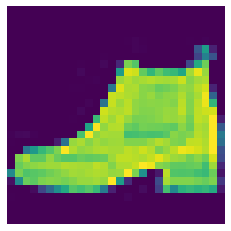

Label: 9


In [5]:
# first batch
train_features, train_labels = next(iter(train_loader))
print(f"Features Batch Shape: {train_features.size()}")
print(f"Labels Batch Shape: {train_labels.size()}")
img = train_features[2].squeeze()
label = train_labels[2]
plt.imshow(img)
plt.axis("off")
plt.show()
print(f"Label: {label}")

(-0.5, 232.5, 464.5, -0.5)

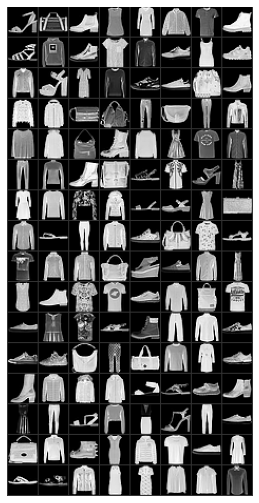

In [6]:
# visualise Batch 
grid_first_batch = make_grid(train_features, padding=1, pad_value=0.2)
plt.figure(figsize=(9,9))
plt.imshow(grid_first_batch.permute(1,2,0))
plt.axis("off")

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using {device}")

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1,4, kernel_size=3,stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        
        self.conv2 = nn.Conv2d(4,8, kernel_size=3,stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        
        self.fc1 = nn.Linear(200,50)
        self.fc2 = nn.Linear(50,10)
        
    
    def forward(self,x,test=False):
        
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
    
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = nn.Flatten()(x)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

using cpu


In [8]:
model_sgd = CNN()
model_adam = CNN()
print(model_sgd)
print(model_adam)

CNN(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
CNN(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [9]:
criterion = nn.CrossEntropyLoss()
acc_metric = Accuracy()

optimizer_sgd = SGD(model_sgd.parameters(), lr=0.001, momentum=0.9)
optimizer_adam = Adam(model_adam.parameters(),lr=0.005,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)

In [10]:
def train(train_loader, optimizer, epochs, model):
    losses, accuracies = [], []
    for epoch in range(epochs):
        model.train()    
        acc_metric.reset()
        for batch_idx, batch in enumerate(train_loader):
            inputs, labels = batch
            optimizer.zero_grad()
            out = model(inputs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
        
            accuracy = acc_metric(nn.functional.softmax(out, dim=1),labels)
            losses.append(loss)
            accuracies.append(accuracy)
    
        print(f"Optimizer: {type (optimizer).__name__} -- Epoch {epoch} -- Loss: {loss} -- Accuracy: {accuracy}")
    return losses, accuracies

In [11]:
losses_sgd, accuracies_sgd = train(train_loader, optimizer_sgd, epochs=8, model=model_sgd)
print("----------")
losses_adam, accuracies_adam = train(train_loader, optimizer_adam, epochs=8, model=model_adam)

Optimizer: SGD -- Epoch 0 -- Loss: 2.276106357574463 -- Accuracy: 0.3125
Optimizer: SGD -- Epoch 1 -- Loss: 2.0073249340057373 -- Accuracy: 0.2708333432674408
Optimizer: SGD -- Epoch 2 -- Loss: 0.9740154147148132 -- Accuracy: 0.6979166865348816
Optimizer: SGD -- Epoch 3 -- Loss: 0.5420979857444763 -- Accuracy: 0.8020833134651184
Optimizer: SGD -- Epoch 4 -- Loss: 0.5704368352890015 -- Accuracy: 0.75
Optimizer: SGD -- Epoch 5 -- Loss: 0.8859074115753174 -- Accuracy: 0.6979166865348816
Optimizer: SGD -- Epoch 6 -- Loss: 0.42045846581459045 -- Accuracy: 0.875
Optimizer: SGD -- Epoch 7 -- Loss: 0.47372671961784363 -- Accuracy: 0.8020833134651184
----------
Optimizer: Adam -- Epoch 0 -- Loss: 0.47821152210235596 -- Accuracy: 0.8229166865348816
Optimizer: Adam -- Epoch 1 -- Loss: 0.5259238481521606 -- Accuracy: 0.8020833134651184
Optimizer: Adam -- Epoch 2 -- Loss: 0.36350134015083313 -- Accuracy: 0.8541666865348816
Optimizer: Adam -- Epoch 3 -- Loss: 0.27521273493766785 -- Accuracy: 0.89583

Text(0.5, 1.0, 'Adam')

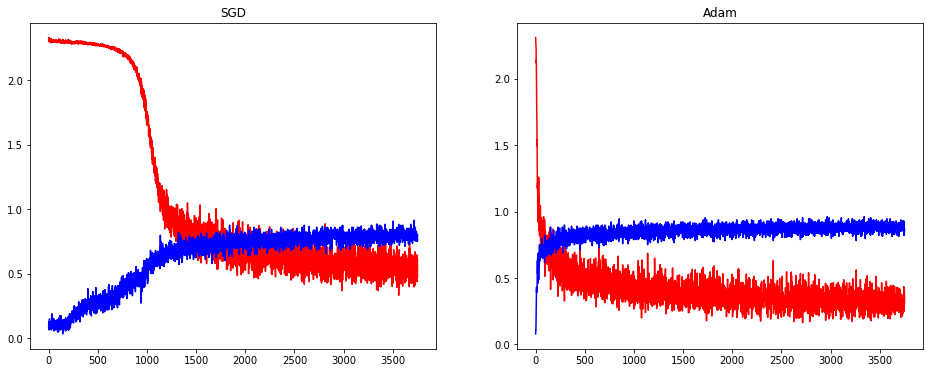

In [12]:
figure, axis = plt.subplots(1, 2, figsize=(16,6))
axis[0].plot(np.linspace(0, len(losses_sgd), len(losses_sgd)).astype(int),losses_sgd, 
                color='r', 
                label='loss')
axis[0].plot(np.linspace(0, len(accuracies_sgd), len(accuracies_sgd)).astype(int),accuracies_sgd, 
                 color='b', 
                 label='accuracy')
axis[0].set_title("SGD")
    
    
axis[1].plot(np.linspace(0, len(losses_adam), len(losses_adam)).astype(int),losses_adam, 
                color='r', 
                label='loss')
axis[1].plot(np.linspace(0, len(accuracies_adam), len(accuracies_adam)).astype(int),accuracies_adam, 
                 color='b', 
                 label='accuracy')
axis[1].set_title("Adam")

In [13]:
# Model on test set
# valid step
models = [model_sgd, model_adam]
for model in models:
    model.eval  # set model into eval mode
    acc_metric.reset()  # delete information from the train step
    # do not calculate gradients 
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            inputs, labels = batch
            output = model(inputs)
            
            # metrics
            loss = criterion(output, labels)
            acc_metric(nn.functional.softmax(output, dim=1), labels)
            print(f' Valid-Acc:{acc_metric.compute()}')
            
    print("------------------------------")

 Valid-Acc:0.765625
 Valid-Acc:0.7890625
 Valid-Acc:0.7942708134651184
 Valid-Acc:0.7890625
 Valid-Acc:0.792187511920929
 Valid-Acc:0.7955729365348816
 Valid-Acc:0.8024553656578064
 Valid-Acc:0.8037109375
 Valid-Acc:0.8046875
 Valid-Acc:0.796875
 Valid-Acc:0.7954545617103577
 Valid-Acc:0.798828125
 Valid-Acc:0.7992788553237915
 Valid-Acc:0.7996651530265808
 Valid-Acc:0.7994791865348816
 Valid-Acc:0.79736328125
 Valid-Acc:0.795036792755127
 Valid-Acc:0.7977430820465088
 Valid-Acc:0.7997533082962036
 Valid-Acc:0.800000011920929
 Valid-Acc:0.7987351417541504
 Valid-Acc:0.7975852489471436
 Valid-Acc:0.7944973111152649
 Valid-Acc:0.7936198115348816
 Valid-Acc:0.7925000190734863
 Valid-Acc:0.7896634340286255
 Valid-Acc:0.7890625
 Valid-Acc:0.7879464030265808
 Valid-Acc:0.787715494632721
 Valid-Acc:0.7864583134651184
 Valid-Acc:0.7862903475761414
 Valid-Acc:0.784912109375
 Valid-Acc:0.7845643758773804
 Valid-Acc:0.7856158018112183
 Valid-Acc:0.7870535850524902
 Valid-Acc:0.7894965410232544
 V